In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyro.infer import HMC, NUTS
from pyro.infer.mcmc import MCMC
import pdb
from src.models import HMC_vanilla

from tqdm import tqdm
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
class GMM():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-5., 0.], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.loc_2 = torch.tensor([5., 0.], dtype=torch.float32, device=device)
        self.covar_2 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        self.distr_2 = torch.distributions.MultivariateNormal(loc=self.loc_2, covariance_matrix=self.covar_2,)
        
        self.p = torch.tensor(0.5, dtype=torch.float32, device=device)
        self.bernoulli = torch.distributions.Bernoulli(probs=self.p)
        
    def log_prob(self, z, x=None):
        samples = z
        return torch.logsumexp(torch.cat([self.p.log() + self.distr_1.log_prob(samples)[None],
                                          (1. - self.p).log() + self.distr_2.log_prob(samples)[None]], dim=0), dim=0)
    
    def energy_function(self, init_params):
        z = init_params['points']
        return -self.log_prob(z)
    
    def sample(self, size):
        c = self.bernoulli.sample(size)[..., None]
        return c * self.distr_1.sample(size) + (1. - c) * self.distr_2.sample(size)
    
class Gaussian():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-5., -2], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.75], [0.75, 1]], dtype=torch.float32, device=device)
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        
    def log_prob(self, z, x=None):
        return self.distr_1.log_prob(z)
    
    def energy_function(self, init_params):
        return -self.distr_1.log_prob(z)
    
    def sample(self, size):
        return self.distr_1.sample(size)

In [5]:
target = GMM(device=device)

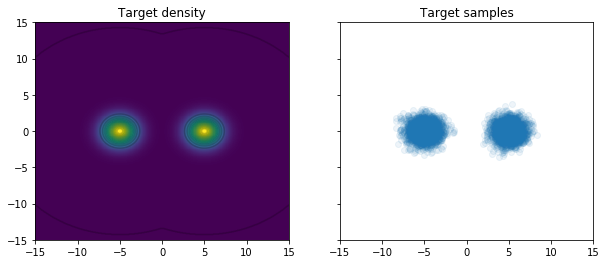

In [6]:
x_lim = 15
y_lim = 15
npts = 500

xside = np.linspace(-x_lim - 1, x_lim + 1, npts)
yside = np.linspace(-y_lim - 1, y_lim + 1, npts)
xx, yy = np.meshgrid(xside, yside)
z = torch.tensor(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]), device=device, dtype=torch.float32)
logdens = target.log_prob(z)
p = np.exp(logdens.cpu().detach().numpy().reshape(npts, npts))

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].set_title('Target density')
ax[0].pcolormesh(xx, yy, p, norm=mcolors.PowerNorm(0.5))
ax[0].contour(xx, yy, p, 15, colors='black', alpha=0.2);
ax[0].set_xlim(-x_lim, x_lim)
ax[0].set_ylim(0, y_lim)
ax[0].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[0].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

ax[1].set_title('Target samples')
samples = target.sample((5000, )).cpu().detach().numpy()
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.075)
ax[1].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[1].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

In [7]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['N'] = 10
args['alpha'] = 0.5
args['gamma'] = 1.
args['use_partialref'] = False
args['use_barker'] = False

In [8]:
mu = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
logvar = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))

transitions = nn.ModuleList([HMC_vanilla(args) for _ in range(100)])

params = [mu, logvar]
optimizer = torch.optim.Adam(params=params, lr=1.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15)

In [9]:
def compute_KL(mu, logvar, z):
    KL = (0.5 * (logvar + torch.exp(logvar) + mu ** 2 - 1.))
    return KL

def ELBO_vanilla(z, mu, logvar, target):
    return target.log_prob(z).mean() - compute_KL(mu, logvar, z).mean()

def VCD(z, mu, logvar, target):
#     pdb.set_trace()
    first_term = -ELBO_vanilla(z, mu, logvar, target)
    z_mcmc = run_mcmc(z.detach())
    second_term = -std_normal.log_prob((z_mcmc - mu) / torch.exp(0.5 * logvar)).mean() + ELBO_vanilla(z_mcmc, mu, logvar, target).detach() * std_normal.log_prob((z - mu) / torch.exp(0.5 * logvar)).mean()
    vcd = first_term + second_term
    return vcd

def run_mcmc_pyro(z):
    z_mcmc = torch.tensor([], device=device, dtype=torch.float32)
    for i in range(z.shape[0]):
        init_samples = z[i]
        init_params = {'points': init_samples}
        mcmc = MCMC(kernel=kernel, num_samples=1, warmup_steps=5, initial_params=init_params, disable_progbar=True)
        mcmc.run()
        z_mcmc = torch.cat([z_mcmc, mcmc._samples['points'].squeeze()[None]], dim=0)
    return z_mcmc

def run_mcmc(z):
    z_mcmc = z
    for i in range(len(transitions)):
        z_mcmc, _, _ = transitions[i].make_transition(z_mcmc, None, target)
    return z_mcmc

In [10]:
batch_size = 100
n_batches = 1000
kernel = HMC(potential_fn=target.energy_function, num_steps=5,)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=device),
                                       scale=torch.tensor(1., dtype=torch.float32, device=device))

  0%|          | 0/1000 [00:00<?, ?it/s]

mu is Parameter containing:
tensor([-1.0000,  1.0000], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 1.0000, -1.0000], device='cuda:0', requires_grad=True)


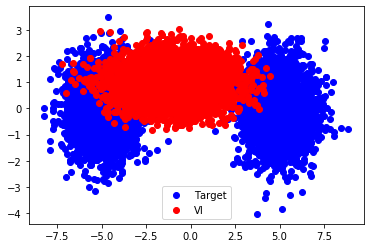

  1%|          | 10/1000 [00:13<22:38,  1.37s/it]

mu is Parameter containing:
tensor([0.1365, 0.4020], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 1.4359, -0.8511], device='cuda:0', requires_grad=True)


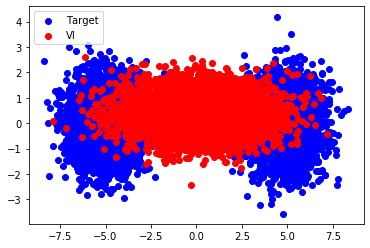

  2%|▏         | 20/1000 [00:27<22:17,  1.36s/it]

mu is Parameter containing:
tensor([ 0.8561, -0.2219], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1251, -0.7251], device='cuda:0', requires_grad=True)


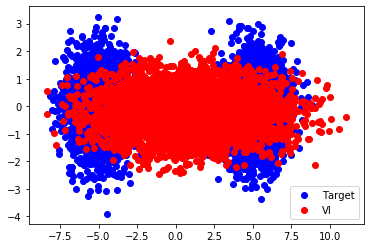

  3%|▎         | 30/1000 [00:41<21:42,  1.34s/it]

mu is Parameter containing:
tensor([0.8348, 0.0552], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1351, -0.7901], device='cuda:0', requires_grad=True)


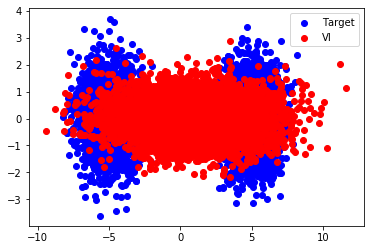

  4%|▍         | 40/1000 [00:54<21:30,  1.34s/it]

mu is Parameter containing:
tensor([0.8318, 0.0605], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1249, -0.7982], device='cuda:0', requires_grad=True)


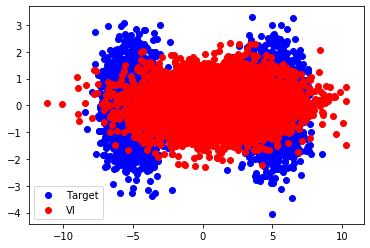

  5%|▌         | 50/1000 [01:08<21:41,  1.37s/it]

mu is Parameter containing:
tensor([0.8364, 0.0570], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1197, -0.8072], device='cuda:0', requires_grad=True)


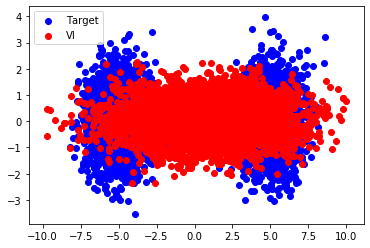

  6%|▌         | 60/1000 [01:22<21:31,  1.37s/it]

mu is Parameter containing:
tensor([0.8347, 0.0555], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1185, -0.8081], device='cuda:0', requires_grad=True)


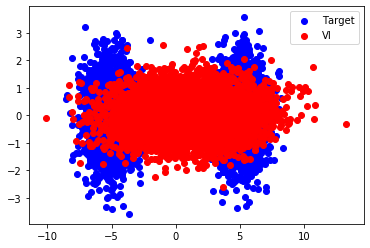

  7%|▋         | 70/1000 [01:35<20:42,  1.34s/it]

mu is Parameter containing:
tensor([0.8344, 0.0554], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1183, -0.8083], device='cuda:0', requires_grad=True)


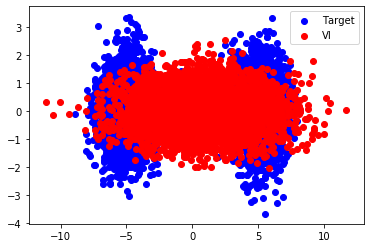

  8%|▊         | 80/1000 [01:49<19:57,  1.30s/it]

mu is Parameter containing:
tensor([0.8343, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1183, -0.8083], device='cuda:0', requires_grad=True)


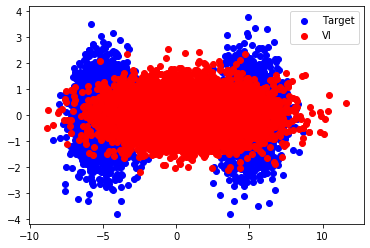

  9%|▉         | 90/1000 [02:02<20:04,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


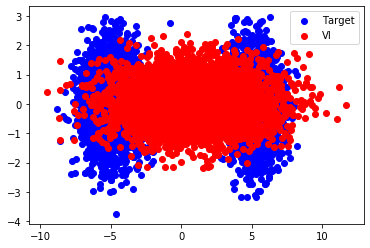

 10%|█         | 100/1000 [02:15<19:49,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


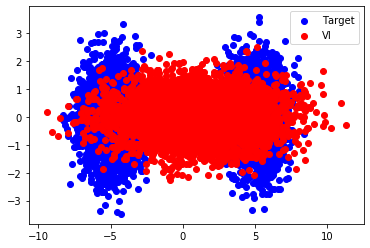

 11%|█         | 110/1000 [02:29<19:34,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


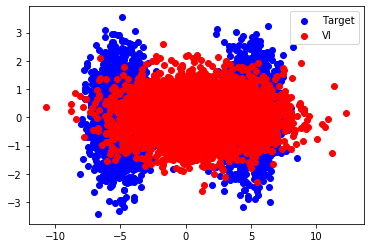

 12%|█▏        | 120/1000 [02:42<19:22,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


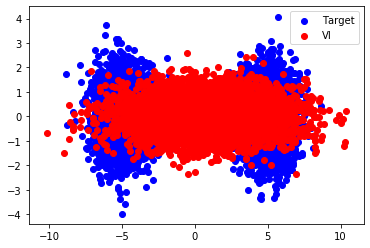

 13%|█▎        | 130/1000 [02:56<19:51,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


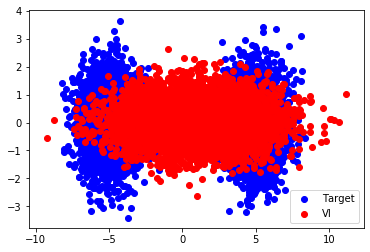

 14%|█▍        | 140/1000 [03:10<19:35,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


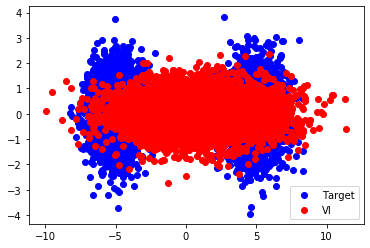

 15%|█▌        | 150/1000 [03:23<19:22,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


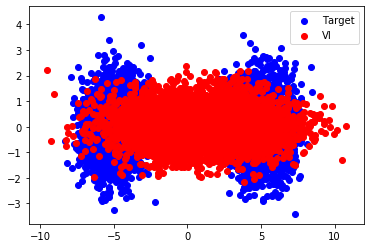

 16%|█▌        | 160/1000 [03:37<19:13,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


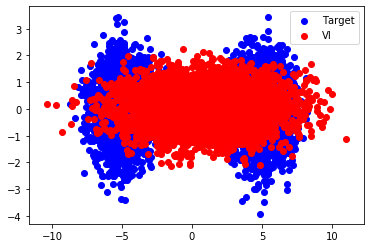

 17%|█▋        | 170/1000 [03:51<18:44,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


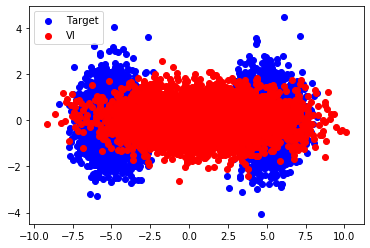

 18%|█▊        | 180/1000 [04:05<18:38,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


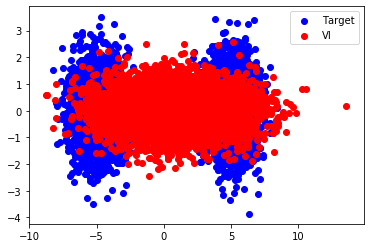

 19%|█▉        | 190/1000 [04:19<18:33,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


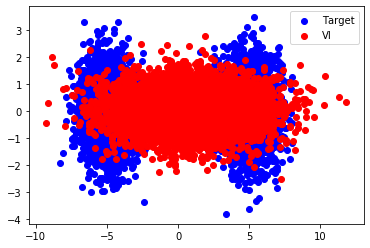

 20%|██        | 200/1000 [04:32<18:10,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


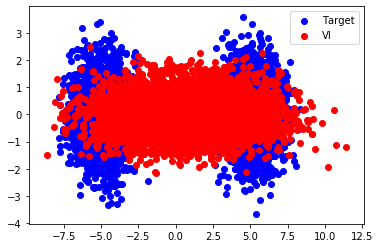

 21%|██        | 210/1000 [04:46<17:39,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


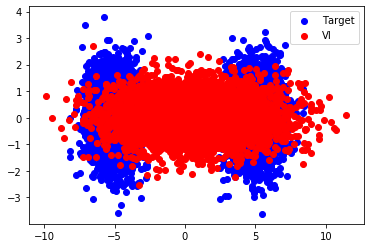

 22%|██▏       | 220/1000 [05:00<17:53,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


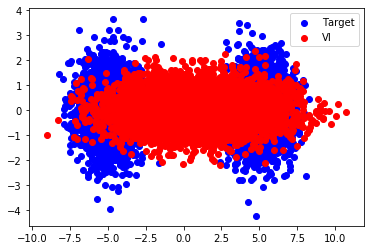

 23%|██▎       | 230/1000 [05:14<17:41,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


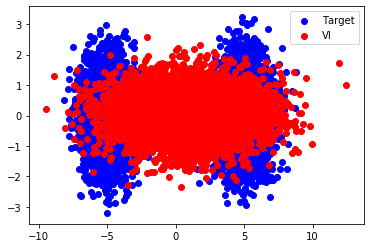

 24%|██▍       | 240/1000 [05:28<17:22,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


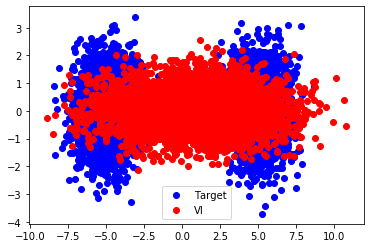

 25%|██▌       | 250/1000 [05:41<17:13,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


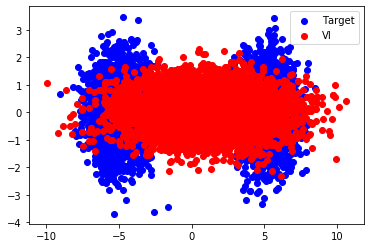

 26%|██▌       | 260/1000 [05:55<16:58,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


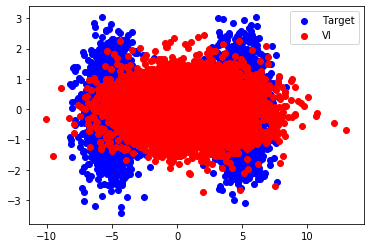

 27%|██▋       | 270/1000 [06:09<16:47,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


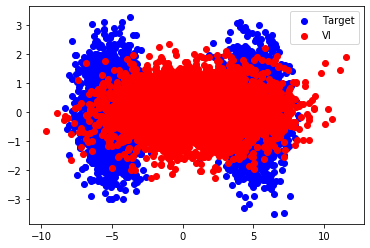

 28%|██▊       | 280/1000 [06:23<16:29,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


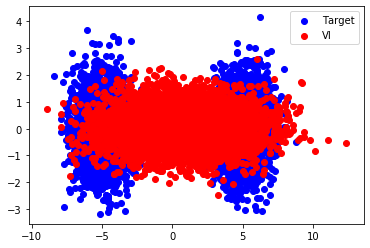

 29%|██▉       | 290/1000 [06:37<16:19,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


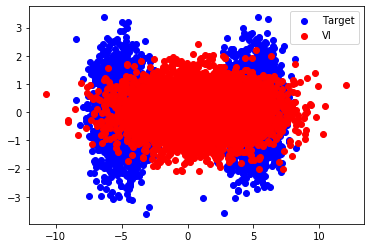

 30%|███       | 300/1000 [06:51<15:39,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


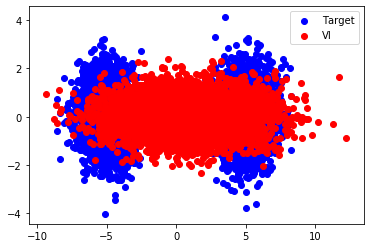

 31%|███       | 310/1000 [07:04<15:47,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


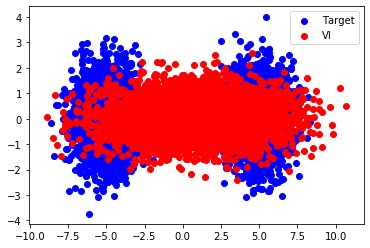

 32%|███▏      | 320/1000 [07:18<15:30,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


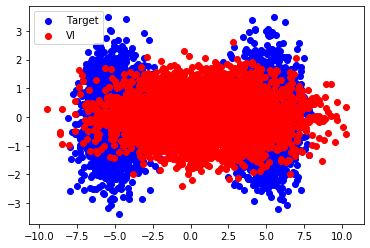

 33%|███▎      | 330/1000 [07:32<15:06,  1.35s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


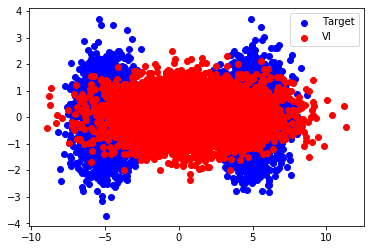

 34%|███▍      | 340/1000 [07:46<15:08,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


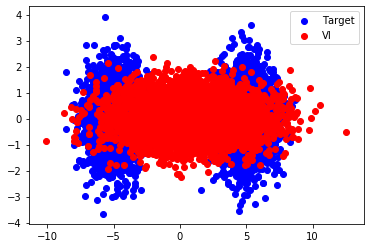

 35%|███▌      | 350/1000 [08:00<14:55,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


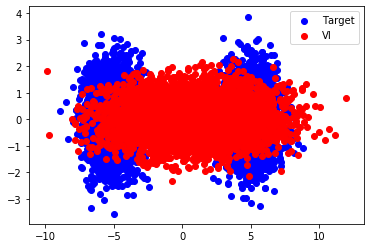

 36%|███▌      | 360/1000 [08:14<14:28,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


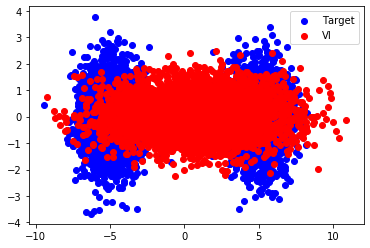

 37%|███▋      | 370/1000 [08:27<14:24,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


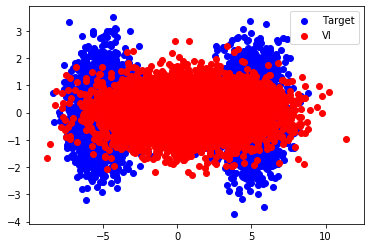

 38%|███▊      | 380/1000 [08:41<13:52,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


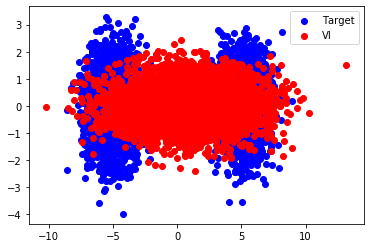

 39%|███▉      | 390/1000 [08:54<13:36,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


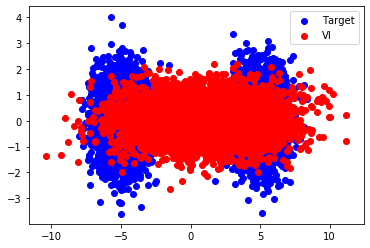

 40%|████      | 400/1000 [09:08<13:22,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


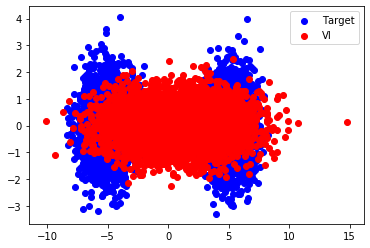

 41%|████      | 410/1000 [09:22<13:13,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


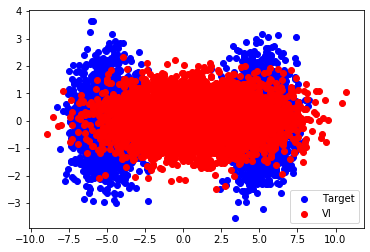

 42%|████▏     | 420/1000 [09:35<13:16,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


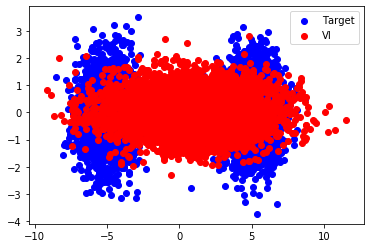

 43%|████▎     | 430/1000 [09:49<12:55,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


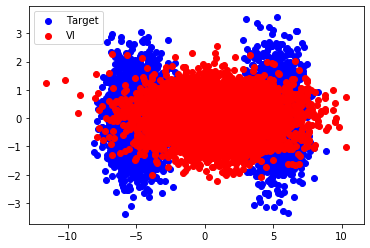

 44%|████▍     | 440/1000 [10:03<12:25,  1.33s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


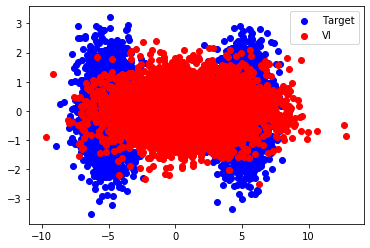

 45%|████▌     | 450/1000 [10:16<12:02,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


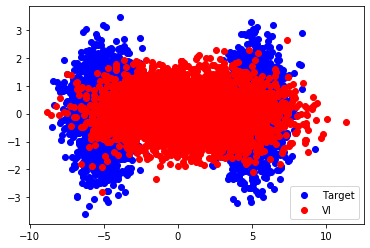

 46%|████▌     | 460/1000 [10:29<11:48,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


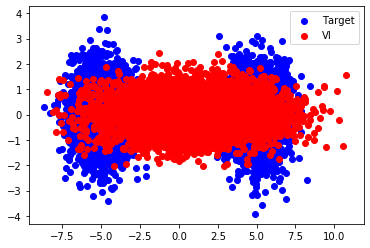

 47%|████▋     | 470/1000 [10:43<11:35,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


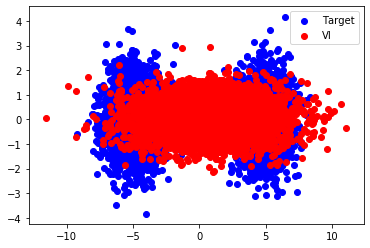

 48%|████▊     | 480/1000 [10:56<11:22,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


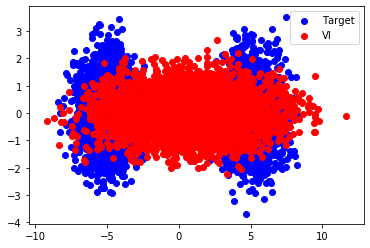

 49%|████▉     | 490/1000 [11:09<11:09,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


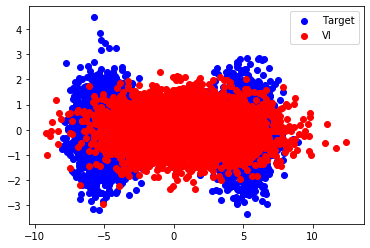

 50%|█████     | 500/1000 [11:22<10:56,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


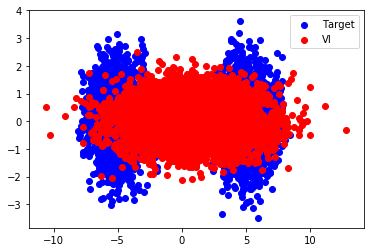

 51%|█████     | 510/1000 [11:36<10:43,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


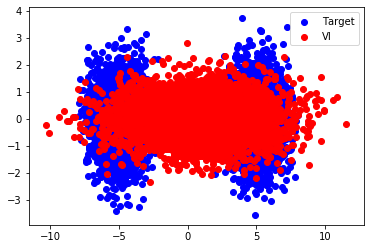

 52%|█████▏    | 520/1000 [11:49<10:55,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


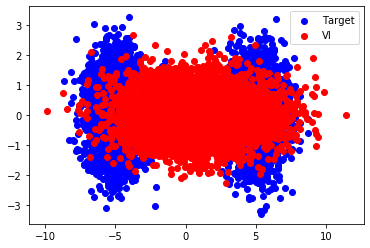

 53%|█████▎    | 530/1000 [12:03<10:47,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


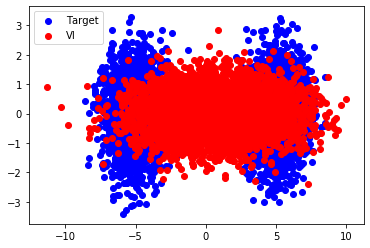

 54%|█████▍    | 540/1000 [12:17<10:30,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


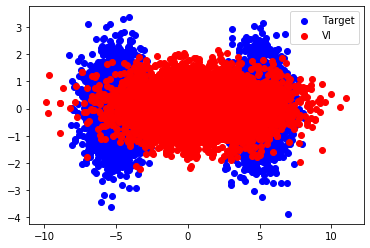

 55%|█████▌    | 550/1000 [12:31<10:09,  1.35s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


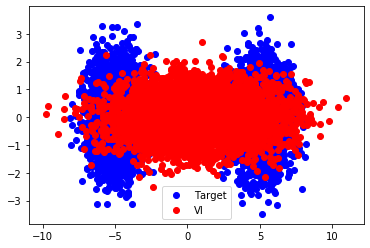

 56%|█████▌    | 560/1000 [12:45<10:05,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


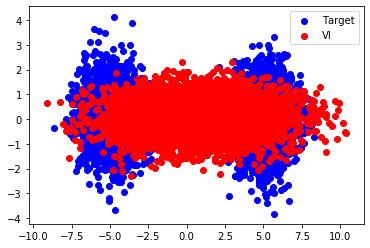

 57%|█████▋    | 570/1000 [12:59<09:51,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


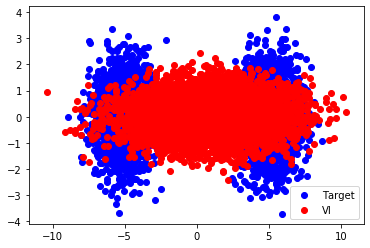

 58%|█████▊    | 580/1000 [13:12<09:36,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


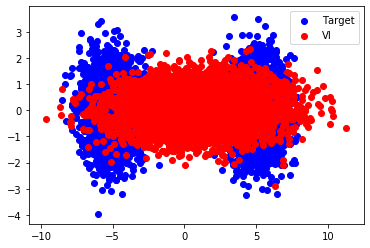

 59%|█████▉    | 590/1000 [13:26<09:04,  1.33s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


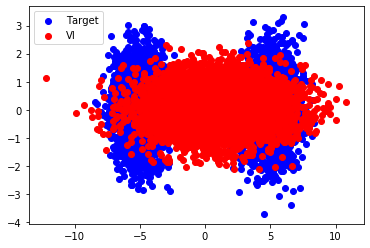

 60%|██████    | 600/1000 [13:39<08:46,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


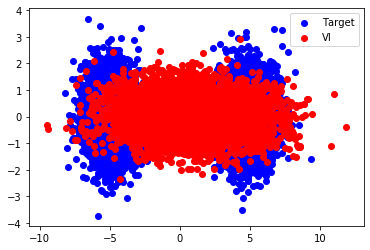

 61%|██████    | 610/1000 [13:53<08:33,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


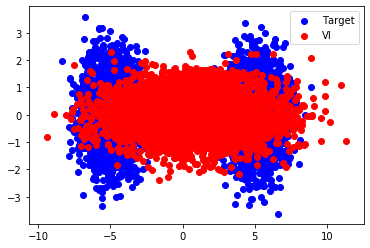

 62%|██████▏   | 620/1000 [14:06<08:19,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


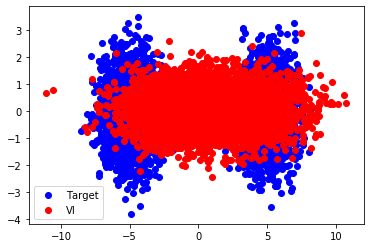

 63%|██████▎   | 630/1000 [14:19<08:15,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


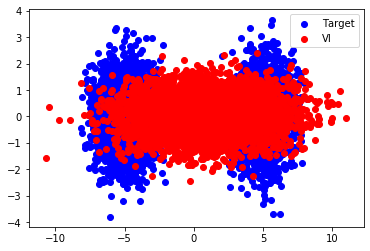

 64%|██████▍   | 640/1000 [14:33<08:12,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


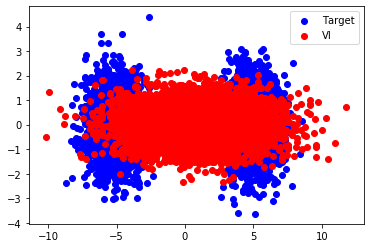

 65%|██████▌   | 650/1000 [14:47<08:01,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


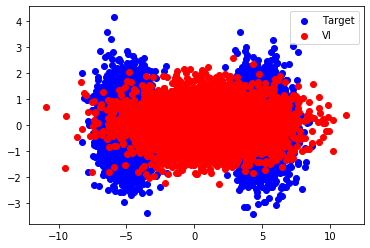

 66%|██████▌   | 660/1000 [15:01<07:49,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


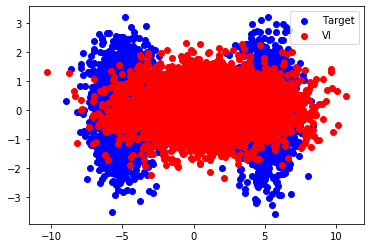

 67%|██████▋   | 670/1000 [15:15<07:27,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


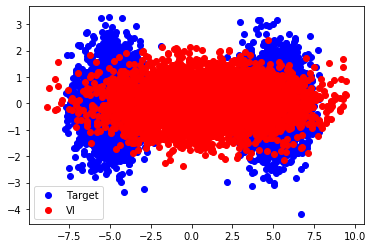

 68%|██████▊   | 680/1000 [15:28<07:16,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


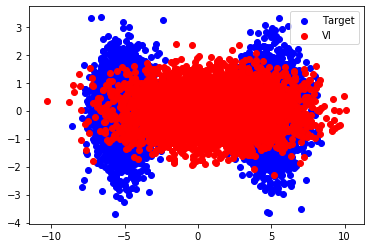

 69%|██████▉   | 690/1000 [15:42<07:01,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


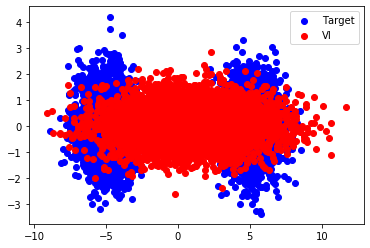

 70%|███████   | 700/1000 [15:56<06:47,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


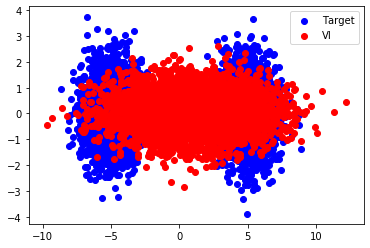

 71%|███████   | 710/1000 [16:09<06:26,  1.33s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


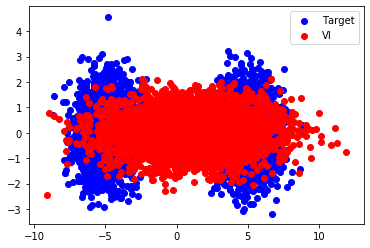

 72%|███████▏  | 720/1000 [16:23<06:18,  1.35s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


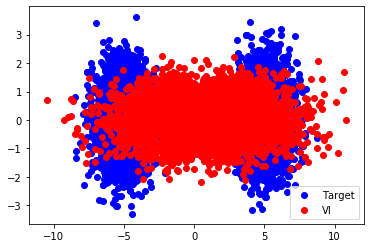

 73%|███████▎  | 730/1000 [16:37<06:10,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


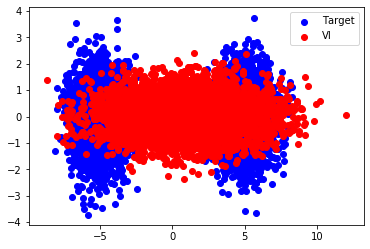

 74%|███████▍  | 740/1000 [16:50<05:53,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


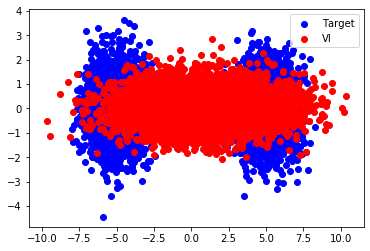

 75%|███████▌  | 750/1000 [17:04<05:39,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


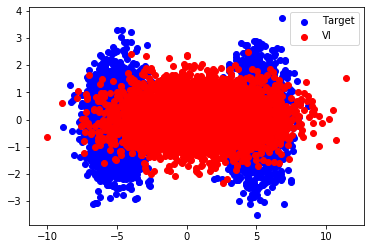

 76%|███████▌  | 760/1000 [17:18<05:21,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


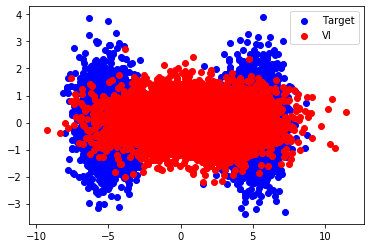

 77%|███████▋  | 770/1000 [17:31<04:58,  1.30s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


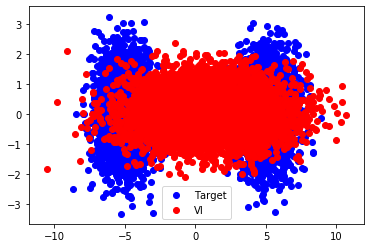

 78%|███████▊  | 780/1000 [17:44<04:45,  1.30s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


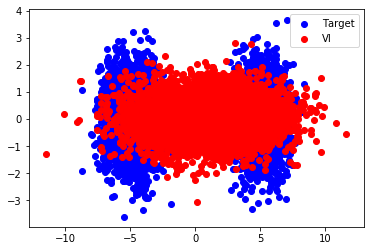

 79%|███████▉  | 790/1000 [17:57<04:32,  1.30s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


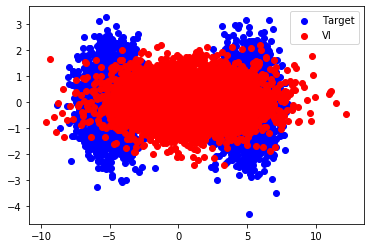

 80%|████████  | 800/1000 [18:10<04:18,  1.29s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


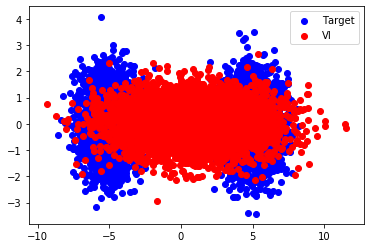

 81%|████████  | 810/1000 [18:23<04:09,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


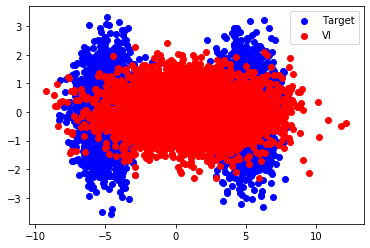

 82%|████████▏ | 820/1000 [18:37<03:56,  1.31s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


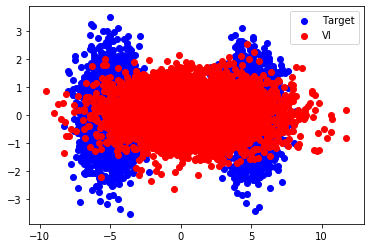

 83%|████████▎ | 830/1000 [18:50<03:47,  1.34s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


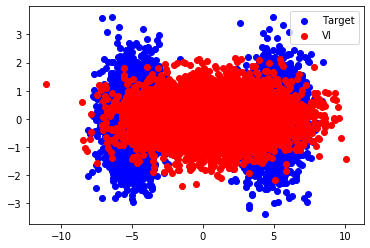

 84%|████████▍ | 840/1000 [19:04<03:38,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


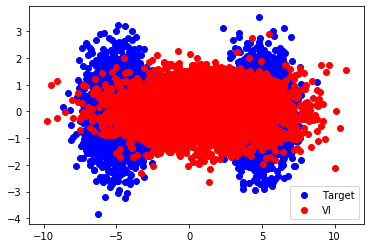

 85%|████████▌ | 850/1000 [19:18<03:24,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


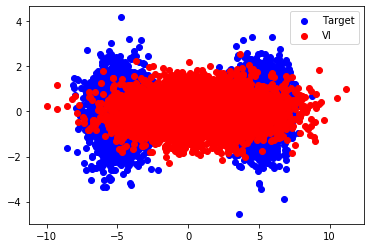

 86%|████████▌ | 860/1000 [19:31<03:11,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


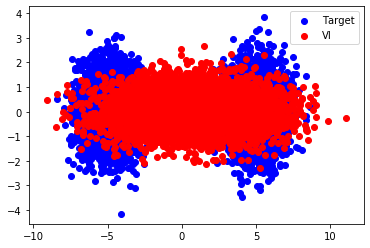

 87%|████████▋ | 870/1000 [19:45<02:56,  1.35s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


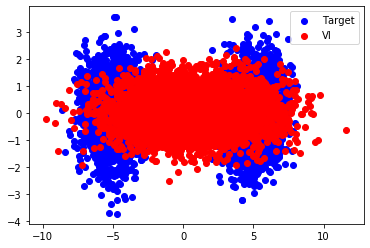

 88%|████████▊ | 880/1000 [19:59<02:43,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


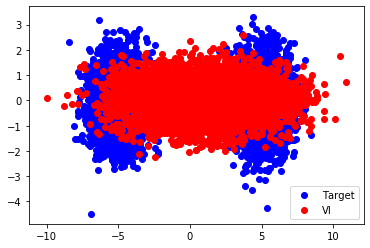

 89%|████████▉ | 890/1000 [20:13<02:30,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


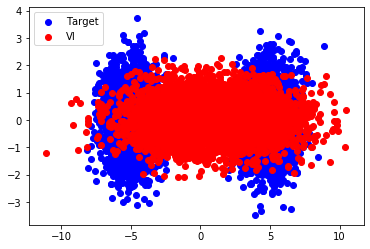

 90%|█████████ | 900/1000 [20:26<02:11,  1.32s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


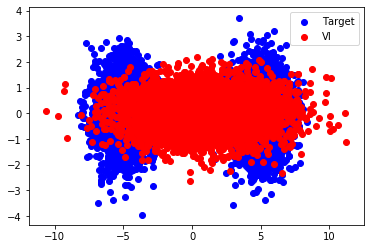

 91%|█████████ | 910/1000 [20:39<01:56,  1.30s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


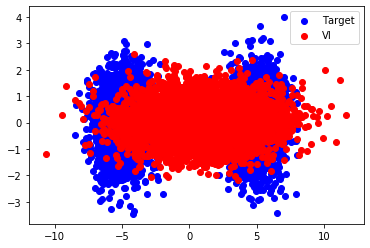

 92%|█████████▏| 920/1000 [20:53<01:44,  1.30s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


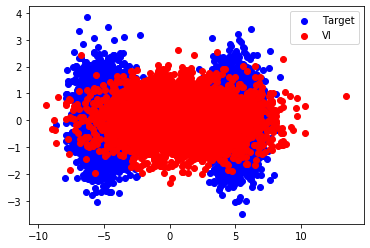

 93%|█████████▎| 930/1000 [21:06<01:35,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


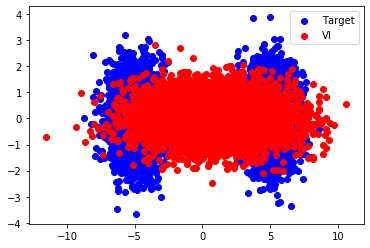

 94%|█████████▍| 940/1000 [21:20<01:22,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


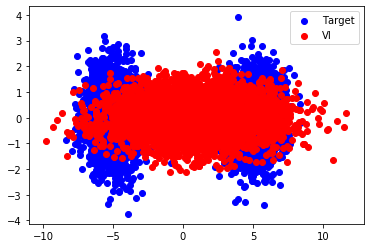

 95%|█████████▌| 950/1000 [21:34<01:08,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


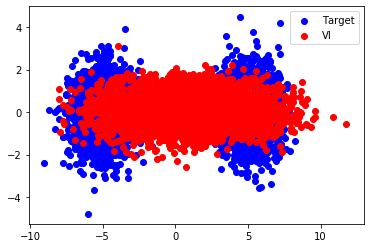

 96%|█████████▌| 960/1000 [21:47<00:54,  1.36s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


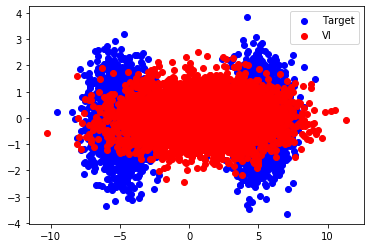

 97%|█████████▋| 970/1000 [22:01<00:41,  1.38s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


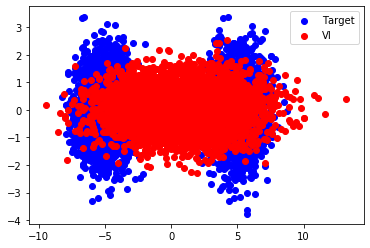

 98%|█████████▊| 980/1000 [22:15<00:27,  1.37s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


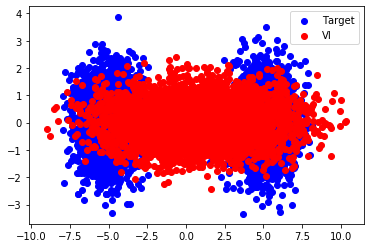

 99%|█████████▉| 990/1000 [22:29<00:13,  1.35s/it]

mu is Parameter containing:
tensor([0.8342, 0.0553], device='cuda:0', requires_grad=True)
logvar is Parameter containing:
tensor([ 2.1182, -0.8083], device='cuda:0', requires_grad=True)


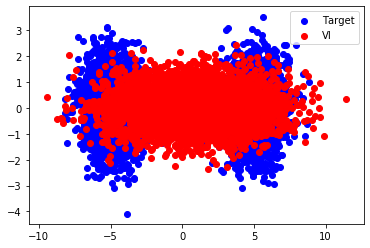

100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


In [11]:
for b_num in tqdm(range(n_batches)):
    plt.close()
    batch = target.sample((batch_size, ))
    eps = std_normal.sample(batch.shape)
    z = mu + eps * torch.exp(logvar * 0.5)
    vcd = VCD(z, mu, logvar, target)
    vcd.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    if b_num % 10 == 0:
        print(f'mu is {mu}')
        print(f'logvar is {logvar}')
        samples_target = target.sample((5000, )).cpu().detach().numpy()
        samples_vi = (mu + std_normal.sample((5000, 2)) * torch.exp(0.5 * logvar)).cpu().detach().numpy()
        plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
        plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VI', c='r')
        plt.legend()
        plt.show()